In [2]:
#!/usr/bin/env python
"""
Demo for tomography test problem on a large scale problem
--------------------------------------------------------------------------
Created in 2023 for TRIPs-Py library
"""
__authors__ = "Mirjeta Pasha, Silvia Gazzola, Connor Sanderford, and Ugochukwu Obinna Ugwu"
__affiliations__ = 'Tufts University, University of Bath, Arizona State University, and Tufts University'
__copyright__ = "Copyright 2023, TRIPs-Py library"
__license__ = "GPL"
__version__ = "1.0"
__email__ = "mirjeta.pasha@tufts.edu; mirjeta.pasha1@gmail.com; sg968@bath.ac.uk; csanderf@asu.edu; connorsanderford@gmail.com; Ugochukwu.Ugwu@tufts.edu"

In [6]:
import matplotlib
import matplotlib.pyplot as plt
from scipy.linalg import fractional_matrix_power
from numpy import array, diag, dot, maximum, empty, repeat, ones, sum
from numpy.linalg import inv
import time
import scipy as sp
import scipy.stats as sps
import scipy.io as spio
import numpy as np
import astra
from trips.utilities.phantoms import *
from venv import create
import pylops
from scipy.ndimage import convolve
from scipy import sparse
import scipy.special as spe
from trips.test_problems.testProblems import *
from trips.solvers.GKS import *
from trips.solvers.MMGKS import *
from trips.solvers.Tikhonov import *
from trips.solvers.tSVD import *
from trips.utilities.helpers import *
from trips.solvers.CGLS import TP_cgls
from trips.solvers.golub_kahan_tikhonov import *
from trips.solvers.GMRES import GMRES
from trips.solvers.Hybrid_GMRES import *
from trips.solvers.Hybrid_LSQR import *
from trips.utilities.operators import *

In [7]:
class Tomography():
    def __init__(self,**kwargs):
        seed = kwargs.pop('seed',2022)
    def define_proj_id(self, sizex, sizey, views, **kwargs):
        self.dataset = kwargs['dataset'] if ('dataset' in kwargs) else False
        self.nx = sizex
        self.ny = sizey
        self.p = int(np.sqrt(2)*self.nx)    # number of detector pixels
        self.q = views           # number of projection angles
        self.views = views
        self.theta = np.linspace(0, 2*np.pi, self.q, endpoint=False)   # in rad
        self.source_origin = 3*self.nx                     # source origin distance [cm]
        self.detector_origin = self.nx                      # origin detector distance [cm]
        self.detector_pixel_size = (self.source_origin + self.detector_origin)/self.source_origin
        self.detector_length = self.detector_pixel_size*self.p   # detector length
        self.vol_geom = astra.create_vol_geom(self.nx,self.nx)
        self.proj_geom = astra.create_proj_geom('fanflat', self.detector_pixel_size, self.p, self.theta, self.source_origin, self.detector_origin)
        self.proj_id = astra.create_projector('line_fanflat', self.proj_geom, self.vol_geom)
        return self.proj_id

    def define_A(self, sizex, sizey, views): 
            proj_id = self.define_proj_id(sizex, sizey, views)  
            self.A = astra.OpTomo(self.proj_id)     
            return self.A

    def forward_Op(self, x, sizex, sizey, views):
        A = self.define_A(sizex, sizey, views)
        operatorf = lambda X: (A*X.reshape((sizex, sizey))).reshape(-1,1)
        operatorb = lambda B: A.T*B.reshape((self.p, self.q))
        OP = pylops.FunctionOperator(operatorf, operatorb, self.p*self.q, sizex*sizey)
        return OP, A

    def gen_true(self, sizex, sizey, test_problem):
        if test_problem == 'grains':
            N_fine = sizex
            numGrains = int(round(4*np.sqrt(N_fine)))
            x_true = phantom.grains(N_fine, numGrains) 
            tmp_shape = x_true.shape
            self.nx = tmp_shape[0]
            self.ny = tmp_shape[1]
            x_truef = x_true.reshape((-1,1)) 
        elif test_problem == 'smooth':
            N_fine = sizex
            x_true = phantom.smooth(N_fine) 
            tmp_shape = x_true.shape
            self.nx = tmp_shape[0]
            self.ny = tmp_shape[1]
            x_truef = x_true.reshape((-1,1)) 
        elif test_problem == 'tectonic':
            N_fine = sizex
            x_true = phantom.tectonic(N_fine)
            tmp_shape = x_true.shape
            self.nx = tmp_shape[0]
            self.ny = tmp_shape[1] 
            x_truef = x_true.reshape((-1,1)) 
        elif test_problem == 'threephases':
            N_fine = sizex
            x_true = phantom.threephases(N_fine) 
            tmp_shape = x_true.shape
            self.nx = tmp_shape[0]
            self.ny = tmp_shape[1]
            x_truef = x_true.reshape((-1,1)) 
        elif test_problem == 'ppower':
            N_fine = sizex
            x_true = phantom.ppower(N_fine) 
            tmp_shape = x_true.shape
            self.nx = tmp_shape[0]
            self.ny = tmp_shape[1]
            x_truef = x_true.reshape((-1,1)) 
        else:
            raise TypeError("You must enter a valid test problem! Options are: grains, smooth, tectonic, threephases, ppower, CT60, CT90, head.")
        return (x_truef, self.nx, self.ny)

    def gen_data(self, x, nx, ny, views):
        self.nx = nx
        self.ny = ny
        self.views = views
        proj_id = self.define_proj_id(self.nx, self.ny, self.views)
        (A, AforMatrixOperation) = self.forward_Op(x, self.nx, self.ny, self.views)
        b = A@x.reshape((-1,1))
        bshape = b.shape
        self.p = self.views
        self.q = int(bshape[0]/self.views)
        bimage = b.reshape((self.p, self.q))
        return A, b, self.p, self.q, AforMatrixOperation
    
    def add_noise(self, b_true, opt, noise_level):
        if (opt == 'Gaussian'):
            # mu_obs = np.zeros((self.p*self.q,1))      # mean of noise
            noise = np.random.randn(b_true.shape[0]).reshape((-1,1))
            e = noise_level * np.linalg.norm(b_true) / np.linalg.norm(noise) * noise
            e = e.reshape((-1,1))
            b_true = b_true.reshape((-1,1))
            delta = la.norm(e)
            b = b_true + e # add noise
            b_meas = b_true + e
            b_meas_i = b_meas.reshape((self.p, self.q))
        elif (opt == 'Poisson'):
            # Add Poisson Noise 
            gamma = 1 # background counts assumed known
            b_meas = np.random.poisson(lam=b_true+gamma) 
            b_meas_i = b_meas.reshape((self.p, self.q))
            delta = 0
        else:
            mu_obs = np.zeros(self.p*self.q)      # mean of noise
            e = np.random.laplace(self.p*self.q)
            sig_obs = noise_level * np.linalg.norm(b_true)/np.linalg.norm(e)
            b_meas = b_true + sig_obs*e
            delta = la.norm(sig_obs*e)
            b_meas_i = b_meas.reshape((self.p, self.q))
        return (b_meas_i , delta)


#### In this notebook we illustrate how to use the Tomography class. The main features are:
1. Define e tomography problem. 

 - 1.2 We use regularization methods for computing an approximate solution



#### 1. Define e tomography problem

###### We define an operator, choose a phantom of any given size and plot the true phantom and the sinograpm as follows:

In [8]:
# Define an object of the class Tomogrpahy
Tomo = Tomography()
# Specify the dimensions of the phantom and the number of angels that we call views
views = 90
nx = 256
ny = 256
# Step 1: Define the true solution throught the function gen_true(). 
# Options are: grains, smooth, tectonic, threephases, ppower
testproblem = 'tectonic'
(x_true, nx, ny) = Tomo.gen_true(nx, ny, testproblem)
# Step 2: Define the forward operator
A = Tomo.forward_Op(x_true, nx, ny, views)
# Generate the data: We can skip Step 1 and generate the sinogram and the operator by the following lines
(A, b_true, p, q, AforMatrixOperation) = Tomo.gen_data(x_true, nx, ny, views)
# Add noise in the true simulated sinogram b_true
# The opt defines the type of the noise. Options are Gaussian, Laplace, and Poisson
# The noise level defines the percentage of the noise added in the data. A value 0.01 means 1% additive noise
(b, delta) = Tomo.add_noise(b_true = b_true, opt = 'Gaussian', noise_level = 0.001)
b_vec = b.reshape((-1,1))

###### Display the true image, the sinogram without noise and the noisy sinogram

(<AxesSubplot:title={'center':'b'}>,
 Text(0.5, 1.0, 'b'),
 (0.0, 1.0, 0.0, 1.0),
 <matplotlib.image.AxesImage at 0x7f8d7b1a5ac0>)

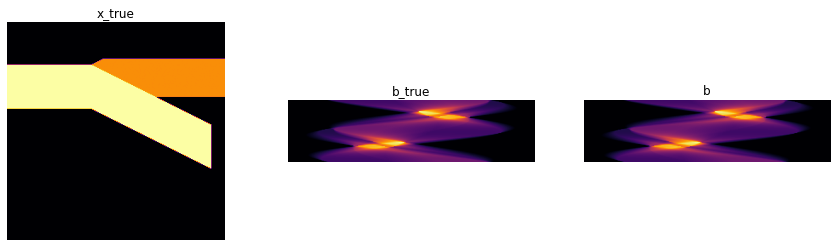

In [9]:
plt.figure(figsize=(15,4))
plt.set_cmap('inferno')
plt.subplot(1,3,1), plt.title('x_true'), plt.axis('off'), plt.imshow(x_true.reshape((nx,ny)))
plt.subplot(1,3,2), plt.title('b_true'), plt.axis('off'), plt.imshow(b_true.reshape((p,q)))
plt.subplot(1,3,3), plt.title('b'), plt.axis('off'), plt.imshow(b.reshape((p,q)))

(-0.5, 361.5, 89.5, -0.5)

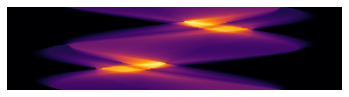

In [21]:
plt.imshow(b.reshape((p, q)))
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

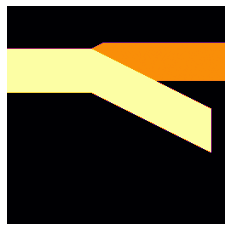

In [22]:
plt.imshow(x_true.reshape((nx, ny)))
plt.axis('off')

#### Solve the problem with MMGKS

In [10]:
# Compute a solution by MMGKS
# Define a derivative operator as a regularization operator
L = spatial_derivative_operator(nx, ny, 1)
data_vec = b.reshape((-1,1))
# Use GKS to compute an approximate solution
(x_mmgks, info_mmgks) = MMGKS(A, data_vec, L, pnorm=2, qnorm=1, projection_dim=2, n_iter =20, regparam = 'gcv', x_true = x_true.reshape((-1,1)), delta = delta)

generating basis...:   0%|          | 0/2 [00:00<?, ?it/s]

running MMGKS...: 100%|██████████| 20/20 [06:15<00:00, 18.77s/it]


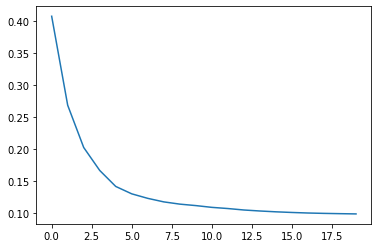

In [11]:
plt.plot(info_mmgks['relError'])


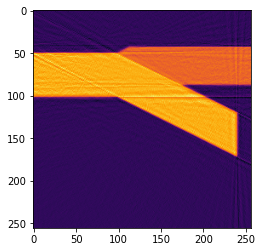

In [12]:
plt.imshow(x_mmgks.reshape((nx,ny)))

###### Display the true image, the sinogram without noise and the noisy sinogram

(<AxesSubplot:title={'center':'x_mmgks'}>,
 Text(0.5, 1.0, 'x_mmgks'),
 (0.0, 1.0, 0.0, 1.0),
 <matplotlib.image.AxesImage at 0x7f8d5e2ed6a0>)

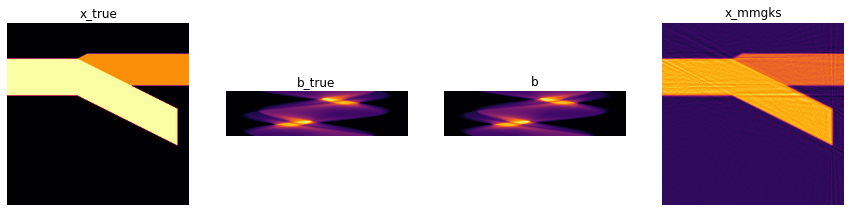

In [15]:
plt.figure(figsize=(15,4))
plt.set_cmap('inferno')
plt.subplot(1,4,1), plt.title('x_true'), plt.axis('off'), plt.imshow(x_true.reshape((nx,ny)))
plt.subplot(1,4,2), plt.title('b_true'), plt.axis('off'), plt.imshow(b_true.reshape((p,q)))
plt.subplot(1,4,3), plt.title('b'), plt.axis('off'), plt.imshow(b.reshape((p,q)))
plt.subplot(1,4,4), plt.title('x_mmgks'), plt.axis('off'), plt.imshow(x_mmgks.reshape((nx,ny)))